# Analysis of model performances on pre/post ambiguity gridsearch

In [468]:
import os
import sys
import json
import re
import pandas as pd
from tqdm import tqdm
from soma import aims

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
    
q = os.path.abspath('../../')
if q not in sys.path:
    sys.path.append(q)
    
from vae import *
from preprocess import SkeletonDataset
import matplotlib.pyplot as plt
import dico_toolbox as dtx
import umap

In [6]:
grid_dict = {}
grid_dir = '/neurospin/dico/lguillon/distmap/gridsearch/'
for folder in os.listdir(grid_dir):
    if 'n_' in folder:
        if os.path.isfile(os.path.join(grid_dir, folder, 'results_test.json')):
            n = re.search('n_([\d]{1,3})', folder).group(1)
            kl = re.search('kl_([\d]{1,2})', folder).group(1)
            with open(os.path.join(grid_dir, folder, 'results_test.json'), 'r') as f:
                grid_dict[(int(n), int(kl))] = json.load(f)

In [12]:
n_list = [list(grid_dict.keys())[k][0] for k in range(len(grid_dict))]
kl_list = [list(grid_dict.keys())[k][1] for k in range(len(grid_dict))]
loss = [[grid_dict[(n_list[k], kl_list[k])] for k in range(len(n_list))][i]['final_loss_val'][0] for i in range(len(grid_dict))]
gb = [[grid_dict[(n_list[k], kl_list[k])] for k in range(len(n_list))][i]['gb_pre'] for i in range(len(grid_dict))]
logreg = [[grid_dict[(n_list[k], kl_list[k])] for k in range(len(n_list))][i]['logreg_pre'] for i in range(len(grid_dict))]
svm = [[grid_dict[(n_list[k], kl_list[k])] for k in range(len(n_list))][i]['svm_pre'] for i in range(len(grid_dict))]

In [16]:
grid_df = pd.DataFrame(list(zip(n_list, kl_list, loss, gb, logreg, svm)), columns=['n', 'kl', 'loss', 'gb','logreg', 'svm'])

In [21]:
grid_df['mean_classif'] = list((grid_df.gb + grid_df.logreg + grid_df.svm)/3)

In [29]:
grid_df.sort_values(by=['mean_classif', 'loss'], ascending=[False, True])

,n,kl,loss,gb,logreg,svm,mean_classif
4,75,4,33194.365420,1.000000,1.000000,1.000000,1.000000
12,150,4,17768.776786,0.969622,1.000000,0.979433,0.983018
8,100,8,21273.862805,0.989899,1.000000,0.948548,0.979482
27,100,10,22304.247617,0.979760,0.979001,0.979001,0.979254
9,150,10,23698.438500,0.917756,1.000000,1.000000,0.972585
22,100,2,15588.968610,0.917714,1.000000,1.000000,0.972571
17,100,4,17481.002720,0.908555,1.000000,0.989553,0.966036
11,50,4,18869.697707,0.908100,0.989880,0.989880,0.962620
15,75,8,20855.845610,0.887250,1.000000,1.000000,0.962417
26,50,8,20850.755557,0.897203,1.000000,0.969313,0.955505


#### Model choice
...

In [37]:
if torch.cuda.is_available():
    device = "cuda:0"

In [442]:
model_dir = '/neurospin/dico/lguillon/distmap/gridsearch/n_20_kl_4/checkpoint.pt'
model_dir = '/neurospin/dico/lguillon/distmap/checkpoint.pt'
model = VAE((1, 80, 80, 96), 20, depth=3)
model.load_state_dict(torch.load(model_dir))
model = model.to(device)

### Data

In [39]:
subject_dir = "/neurospin/dico/lguillon/distmap/data/"
data_dir = "/neurospin/dico/lguillon/distmap/data/"

test_list = pd.read_csv(os.path.join(subject_dir, "test_list.csv"))

In [102]:
data_dir = "/neurospin/dico/data/deep_folding/current/datasets/hcp/crops/1mm/SC/no_mask/Rdistmaps"
tgt_dir = '/neurospin/dico/lguillon/distmap/data'

list_sample_id = []
list_sample_file = []

for sub in tqdm(test_list.subjects):
    distmap = os.path.join(data_dir, f"{sub}_cropped_distmap.nii.gz")
    vol = aims.read(distmap)
    sample = np.asarray(vol)
    list_sample_id.append(sub)
    list_sample_file.append(sample)

list_sample_id = np.array(list_sample_id)
list_sample_file = np.array(list_sample_file)
np.save(os.path.join(tgt_dir, 'test_sub_id.npy'), list_sample_id)
np.save(os.path.join(tgt_dir, 'test_distmap.npy'), list_sample_file)
print("test set saved !")

100%|██████████| 200/200 [00:24<00:00,  8.16it/s]


test set saved !


In [103]:
list_sample_file.shape

(200, 78, 63, 88, 1)

In [107]:
data_dir = "/neurospin/dico/lguillon/distmap/data/"

distmaps = np.load(os.path.join(data_dir, "test_distmap.npy"),
                   mmap_mode='r')
filenames = np.load(os.path.join(data_dir, "test_sub_id.npy"))

print(distmaps.shape, filenames.shape)

subset = SkeletonDataset(dataframe=distmaps,
                         filenames=filenames,
                         data_transforms=False)

testloader = torch.utils.data.DataLoader(
               subset,
               batch_size=1,
               num_workers=1,
               shuffle=False) 

(200, 78, 63, 88, 1) (200,)


##### SC int
[111009, 138231, 510225, 199251, 159946, 140319, 212419] 

In [86]:
scint_list = ['111009', '138231', '510225', '199251', '159946', '140319', '212419']
scint_arr = np.array(['111009', '138231', '510225', '199251', '159946', '140319', '212419'])

data_dir = "/neurospin/dico/data/deep_folding/current/datasets/hcp/crops/1mm/SC/no_mask/Rdistmaps"

distmaps = np.load(os.path.join(data_dir, "distmap_1mm.npy"), mmap_mode='r')
filenames = np.load(os.path.join(data_dir, "sub_id.npy"))

ids = np.frompyfunc(lambda x: np.isin(x, scint_arr), 1, 1)(filenames)
idxs = [i for i, curr in enumerate(ids) if curr.any()]

filenames_scint = filenames[idxs]
distmaps_scint = distmaps[idxs]

print(distmaps_scint.shape, filenames_scint.shape)

subset_scint = SkeletonDataset(dataframe=distmaps_scint,
                         filenames=filenames_scint,
                         data_transforms=False)

scint_loader = torch.utils.data.DataLoader(
               subset_scint,
               batch_size=1,
               num_workers=1,
               shuffle=False) 

(7, 78, 63, 88, 1) (7,)


In [443]:
dico_set_loaders = {'hcp': testloader, 'scint': scint_loader}

root_dir = '/neurospin/dico/lguillon/distmap/analyses_gridsearch/'

criterion = nn.MSELoss(reduction='sum')
tester = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=4,
                     n_latent=20, depth=3)

In [444]:
results = tester.test()
encoded = {loader_name:[results[loader_name][k][1] for k in results[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
losses = {loader_name:[int(results[loader_name][k][0].cpu().detach().numpy()) for k in results[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

df_encoded = pd.DataFrame()
df_encoded['latent'] = encoded['hcp'] + encoded['scint'] 
df_encoded['Group'] = ['hcp' for k in range(len(filenames))] + ['scint' for k in range(len(filenames_scint))]


hcp
scint


In [445]:
X = np.array(list(df_encoded['latent']))
labels = np.array(df_encoded['Group'])

from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, random_state=12, perplexity=20).fit_transform(X)

In [252]:
subjects_name = [str(k) for k in filenames] + scint_list 

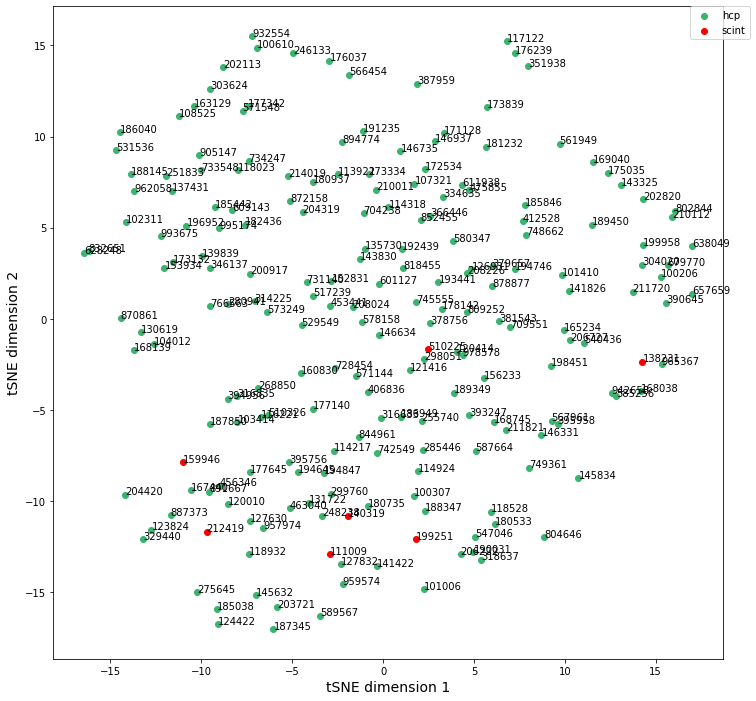

In [446]:
arr = X_embedded
color_dict = {'hcp':'mediumseagreen', 'scint': 'red'}

fig = plt.figure(figsize=(12,12))
ax = fig.subplots()

for g in np.unique(labels):
    ix = np.where(labels == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name):
    ax.annotate(txt, (arr[i][0], arr[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

In [236]:
sub = {loader_name:np.array([int(k) for k in results[loader_name].keys()]) for loader_name in dico_set_loaders.keys()}


In [447]:
np.where(sub['hcp']==872158)

(array([21]),)

In [448]:
np.where(np.array(losses['hcp'])>3000)

(array([  2,   3,  19,  21,  27,  28,  31,  41,  43,  48,  65,  71,  72,
         77,  83,  91,  92,  96,  98, 100, 118, 119, 122, 125, 126, 129,
        149, 155, 158, 166, 168, 179, 194, 195, 199]),)

In [449]:
sub['hcp'][71]

329440

In [259]:
results['scint'].keys()

dict_keys(['138231', '510225', '159946', '140319', '212419', '199251', '111009'])

In [450]:
losses['scint']

[3152, 3376, 3060, 2545, 3610, 3016, 3605]

(array([1., 0., 0., 0., 2., 1., 0., 1., 0., 2.]),
 array([2545. , 2651.5, 2758. , 2864.5, 2971. , 3077.5, 3184. , 3290.5,
        3397. , 3503.5, 3610. ]),
 <BarContainer object of 10 artists>)

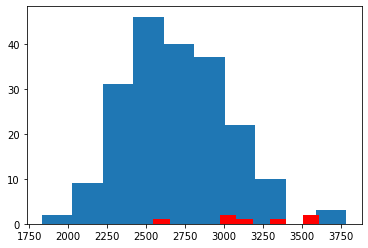

In [451]:
plt.subplot()
plt.hist(losses['hcp'])
plt.hist(losses['scint'], color='r')

In [216]:
from scipy import stats

In [452]:
print(np.std(losses['hcp']))
print(np.std(losses['scint']))

330.64370914928963
347.9944287614093


In [453]:
from scipy.stats import mannwhitneyu

In [454]:
F,p = mannwhitneyu(losses['hcp'], losses['scint'])
print(p)

0.0010872919720368247


In [354]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(X)
for k in range(200, 207):
    print(neigh.kneighbors(np.expand_dims(X[k], axis=0)))

(array([[0.        , 8.2017856 , 8.78346588, 8.86557332]]), array([[200,  21, 148, 142]]))
(array([[0.        , 7.12290098, 7.48523356, 7.84563524]]), array([[201,  28, 136,  77]]))
(array([[0.        , 6.64112742, 7.47256523, 7.69703071]]), array([[202, 146, 118, 106]]))
(array([[0.        , 8.12191881, 8.29307813, 8.35286344]]), array([[203, 136, 103,  54]]))
(array([[0.        , 8.086333  , 8.2446649 , 8.27056778]]), array([[204, 151, 125, 165]]))
(array([[0.        , 8.23194352, 8.35033652, 8.4423202 ]]), array([[205, 130,  34, 188]]))
(array([[0.        , 8.19521908, 8.49863777, 8.52180497]]), array([[206,  68,  29, 158]]))


In [455]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(X)
for k in range(200, 207):
    print(neigh.kneighbors(np.expand_dims(X[k], axis=0)))

(array([[0.        , 4.28042629, 4.5844767 , 4.60999317]]), array([[200,   6,  73,  21]]))
(array([[0.        , 4.82277583, 4.91657172, 5.16597147]]), array([[201,  93,   3,  77]]))
(array([[0.        , 3.77524826, 4.27959744, 4.37225076]]), array([[202, 146, 193,  16]]))
(array([[0.        , 4.65150307, 5.06077542, 5.10671035]]), array([[203, 103, 152, 164]]))
(array([[0.        , 4.86590372, 4.96956701, 5.25511175]]), array([[204, 179, 133,  20]]))
(array([[0.        , 4.24243194, 4.58893964, 4.83078642]]), array([[205,  73,  54, 182]]))
(array([[0.        , 4.81408641, 5.01018873, 5.27683332]]), array([[206, 133, 200,  49]]))


In [390]:
sub['hcp'][49]

168139

In [280]:
filenames_scint

array(['138231', '510225', '159946', '140319', '212419', '199251',
       '111009'], dtype='<U6')

### Study of reconstruction error as anomaly score

In [394]:
idx = np.where(np.array(losses['hcp'])>3000)

In [401]:
sub['hcp'][idx]

array([887373, 704238, 679770, 124422, 872158, 942658, 168038, 802844,
       116221, 100206, 172534, 329440, 180937, 965367, 351938, 185038,
       145632, 199958, 121416, 731140, 135730, 104012, 117122, 176239,
       123824, 275645, 189450, 167440, 891667, 139839, 120010, 510326,
       456346, 573249, 175035, 211720])

In [464]:
enc = encoded['hcp'][10]

In [417]:
enc.shape

(20,)

In [465]:
arr_out = []
values = []

z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())

# arr_out = np.array(arr_out)
# np.save(f"/volatile/arr_out.npy", arr_out)
# np.save('/volatile/arr_label.npy', np.array(values))

In [466]:
out[out>0.5] = 1
out[out<=0.5] = 0

In [467]:
aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), voxel_size=(1,1,1)), f"/volatile/bucket_test.bck")